In [1]:
% pylab inline
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# utils
from scipy.misc import imread
from scipy.misc import imresize
import os
import random

# Configure visualisations
%matplotlib inline
color = sns.color_palette()
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 10,8 


Populating the interactive namespace from numpy and matplotlib


In [28]:
def bar_plot(df, col, text = True, k = None, rot = 0):
    """
    Arguments:
    x : pandas series
    Returns:
    seaborn barplot with text on top
    """
    if k == None:
        x = df[col].value_counts()
    else:
        x = df[col].value_counts()[:k]
    ax= sns.barplot(x.index, x.values, alpha=0.8)
    plt.title("# per class")
    plt.ylabel('# of Occurrences', fontsize=12)
    plt.xlabel(col, fontsize=12)
    #adding the text labels
    if text:
        rects = ax.patches
        labels = x.values
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    plt.xticks(rotation = rot)
    plt.show()

In [2]:
# set the root path
root_dir = os.path.abspath('.')
# set the data dir
data_dir = '../input'

In [3]:
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'test.csv'))

In [4]:
train.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [5]:
print("Train shape :",train.shape)
print("Test shape :",test.shape)

('Train shape :', (19906, 2))
('Test shape :', (6636, 1))


In [6]:
def show_random_image(df, folder_name):
    i = random.choice(df.index)

    img_name = df.ID[i]
    img = imread(os.path.join(data_dir, folder_name, img_name))

    print('Age : ', train.Class[i])
    imshow(img)
    

('Age : ', 'YOUNG')


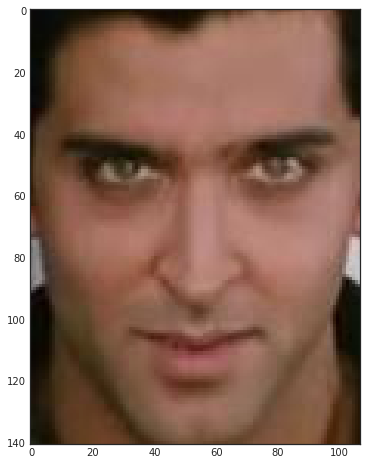

In [10]:
# show random image 
show_random_image(train, "train")

In [22]:
def resize_img(df, folder_name):
    temp = []
    for index,img_name in enumerate(df.ID):
        if index % 1000 == 0:
            print 'Index :',index
        img_path = os.path.join(data_dir, folder_name, img_name)
        img = imread(img_path)
        img = imresize(img, (32, 32))
        img = img.astype('float32')
        temp.append(img)

    return np.stack(temp)
    

In [20]:
%%time
# resize all the images 32 x 32 (training set), usually takes ~ 4-5 min (CPU)
train_x = resize_img(train, "train")

Index : 0
Index : 1000
Index : 2000
Index : 3000
Index : 4000
Index : 5000
Index : 6000
Index : 7000
Index : 8000
Index : 9000
Index : 10000
Index : 11000
Index : 12000
Index : 13000
Index : 14000
Index : 15000
Index : 16000
Index : 17000
Index : 18000
Index : 19000
CPU times: user 32.9 s, sys: 1.82 s, total: 34.7 s
Wall time: 2min 49s


In [23]:
# resize all the images 32 x 32 (testing set)
test_x = resize_img(test, "test")

Index : 0
Index : 1000
Index : 2000
Index : 3000
Index : 4000
Index : 5000
Index : 6000


In [24]:
# flatten the image array
train_x = train_x / 255
test_x = test_x / 255

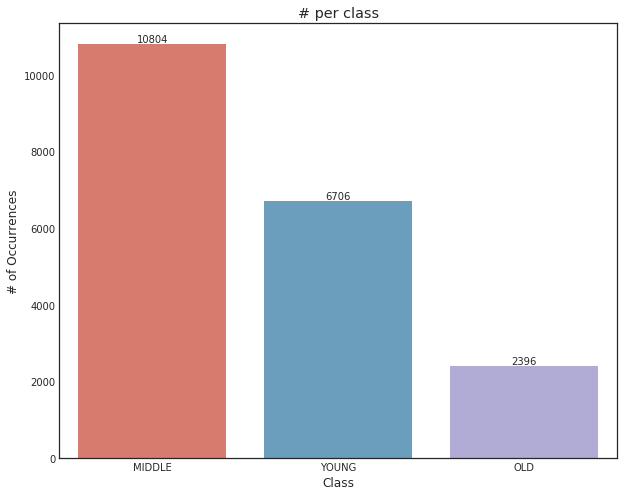

In [29]:
bar_plot(train, "Class")

In [33]:
import keras
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
train_y = lb.fit_transform(train.Class)
train_y = keras.utils.np_utils.to_categorical(train_y)

In [34]:
# set up the parameters for neural network
input_num_units = (32, 32, 3)
hidden_num_units = 600
output_num_units = 3
num_filter = 100

epochs = 30
batch_size = 64

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer
from keras.layers import Conv2D, MaxPooling2D, Dropout

In [36]:
model = Sequential()

## Input Layer
model.add(InputLayer(input_shape=input_num_units))

## Convolutional layer
model.add(Conv2D(num_filter, (3, 3), activation='relu', input_shape=input_num_units))

model.add(MaxPooling2D())

model.add(Dropout(0.25))

model.add(Conv2D(int(num_filter * 0.5), (3, 3), activation='relu', input_shape=(10, 10, 100)))

model.add(MaxPooling2D())

model.add(Dropout(0.25))

model.add(Conv2D(int(num_filter * 0.3), (3, 3), activation='relu', input_shape=(1, 1, 10)))

model.add(Flatten())

model.add(Dense(hidden_num_units, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(int(hidden_num_units * 0.2), activation='relu'))

model.add(Dense(units=output_num_units, activation='softmax'))

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 100)       2800      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 100)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 50)        45050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 50)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 50)          0         
__________

In [38]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(train_x, train_y, batch_size=batch_size,epochs=epochs,verbose=1)

In [39]:
model.fit(train_x, train_y, batch_size=batch_size,epochs=epochs,verbose=1, validation_split=0.1)

Train on 17915 samples, validate on 1991 samples
Epoch 1/30
17915/17915 [==============================] - 75s 4ms/step - loss: 0.9195 - acc: 0.5566 - val_loss: 0.8503 - val_acc: 0.6168
Epoch 2/30
17915/17915 [==============================] - 76s 4ms/step - loss: 0.8099 - acc: 0.6366 - val_loss: 0.7488 - val_acc: 0.6801
Epoch 3/30
17915/17915 [==============================] - 83s 5ms/step - loss: 0.7498 - acc: 0.6691 - val_loss: 0.7149 - val_acc: 0.6936
Epoch 4/30
17915/17915 [==============================] - 84s 5ms/step - loss: 0.7190 - acc: 0.6858 - val_loss: 0.6977 - val_acc: 0.6886
Epoch 5/30
17915/17915 [==============================] - 78s 4ms/step - loss: 0.6931 - acc: 0.6996 - val_loss: 0.6779 - val_acc: 0.7062
Epoch 6/30
17915/17915 [==============================] - 83s 5ms/step - loss: 0.6720 - acc: 0.7104 - val_loss: 0.7059 - val_acc: 0.6966
Epoch 7/30
17915/17915 [==============================] - 84s 5ms/step - loss: 0.6464 - acc: 0.7223 - val_loss: 0.6506 - val_acc:

In [44]:
pred_train = model.predict_classes(train_x, verbose=1)
pred = model.predict_classes(test_x, verbose=1)
pred = lb.inverse_transform(pred)

test['Class'] = pred
test.to_csv('submission.csv', index=False)

6636/6636 [==============================] - 8s 1ms/step


('Original : ', 'MIDDLE', 'Predicted:', 'MIDDLE')


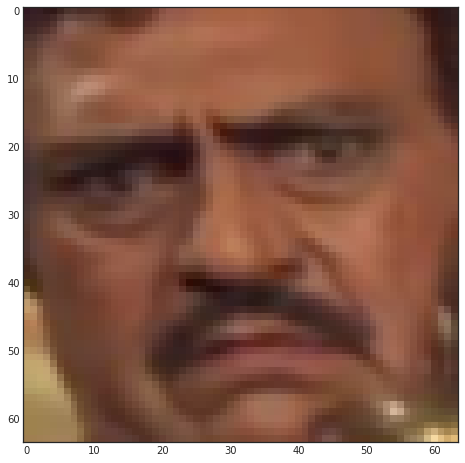

In [48]:
i = random.choice(train.index)
img_name = train.ID[i]

img = imread(os.path.join(data_dir, 'train', img_name)).astype('float32')
imshow(imresize(img, (64, 64)))
print("Original : ", train.Class[i], 'Predicted:', lb.inverse_transform(pred_train[i]))